In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import json

# Cargar datos de todos los trabajos
with open('trabajos.json', 'r') as file:
    all_jobs_data = json.load(file)

# Lista para almacenar los datos procesados
lista_trabajos = []

# Iterar sobre cada trabajo en los datos de todas las categorías
for job in all_jobs_data:
    atributos = job['attributes']
    company_attributes = atributos.get('company', {}).get('data', {}).get('attributes', {})

    trabajos_data = {
    'job_id': job.get('id', ''),
    'job_type': job.get('type', ''),
    'title': atributos.get('title', ''),
    'description_headline': atributos.get('description_headline', ''),
    'description': atributos.get('description', ''),
    'projects': atributos.get('projects', ''),
    'functions_headline': atributos.get('functions_headline', ''),
    'functions': atributos.get('functions', ''),
    'benefits_headline': atributos.get('benefits_headline', ''),
    'benefits': atributos.get('benefits', ''),
    'desirable_headline': atributos.get('desirable_headline', ''),
    'desirable': atributos.get('desirable', ''),
    'remote': atributos.get('remote', ''),
    'remote_modality': atributos.get('remote_modality', ''),
    'remote_zone': atributos.get('remote_zone', ''),
    'countries': ', '.join(atributos.get('countries', [])),
    'lang': atributos.get('lang', ''),
    'category_name': atributos.get('category_name', ''),
    'perks': ', '.join(atributos.get('perks', [])),
    'min_salary': atributos.get('min_salary', 0),
    'max_salary': atributos.get('max_salary', 0),
    'published_at': atributos.get('published_at', 0),
    'response_time_in_days_min': atributos.get('response_time_in_days', {}).get('min', None),
    'response_time_in_days_max': atributos.get('response_time_in_days', {}).get('max', None),
    'applications_count': atributos.get('applications_count', 0),
    'location_regions': ', '.join([str(region['id']) for region in atributos.get('location_regions', {}).get('data', [])]),
    'location_tenants': ', '.join([str(tenant['id']) for tenant in atributos.get('location_tenants', {}).get('data', [])]),
    'location_cities': ', '.join([str(city['id']) for city in atributos.get('location_cities', {}).get('data', [])]),
    'modality': atributos.get('modality', {}).get('data', {}).get('attributes', {}).get('name', ''),
    'seniority': atributos.get('seniority', {}).get('data', {}).get('attributes', {}).get('name', ''),
    'tags': ', '.join([tag['attributes']['name'] for tag in atributos.get('tags', {}).get('data', [])]),
    'company_id': company_attributes.get('id', ''),
    'company_type': company_attributes.get('type', ''),
    'company_name': company_attributes.get('name', ''),
    'company_description': company_attributes.get('description', ''),
    'company_long_description': company_attributes.get('long_description', ''),
    'company_web': company_attributes.get('web', ''),
    'company_twitter': company_attributes.get('twitter', ''),
    'company_github': company_attributes.get('github', ''),
    'company_facebook': company_attributes.get('facebook', ''),
    'company_angellist': company_attributes.get('angellist', ''),
    'company_country': company_attributes.get('country', ''),
    'company_logo': company_attributes.get('logo', ''),
    'links': job.get('links', {}).get('public_url', '')
}



    # Añadir el diccionario a la lista
    lista_trabajos.append(trabajos_data)

# Crear el DataFrame
trabajos_df = pd.DataFrame(lista_trabajos)


"""
MarkupResemblesLocatorWarning: The input looks more like a filename than markup. 
You may want to open this file and pass the filehandle into Beautiful Soup.
soup = BeautifulSoup(texto_html, 'html.parser')
"""

# Funcion para limpiar el texto HTML
def limpiar_html(texto_html):
    if not texto_html or not isinstance(texto_html, str):
        return ""
    elif '<' not in texto_html and '>' not in texto_html:
        return texto_html.strip()  
    else:
        soup = BeautifulSoup(texto_html, 'html.parser')
        return soup.get_text(separator=" ", strip=True)


# Llamar a la función limpiar_html en las categorias que incluyen notaciones HTML
campos_texto_largo = ['description', 'projects', 'functions', 'benefits', 'desirable', 'company_description']
for campo in campos_texto_largo:
    trabajos_df[campo] = trabajos_df[campo].apply(limpiar_html)

# Lista para definir el orden de las columnas
columnas_finales = [ 'category_name','job_id','min_salary', 'max_salary', 'remote', 'remote_modality', 'countries', 'modality', 'seniority','perks',
       'projects', 'functions','benefits', 'description', 'desirable','company_name','company_country', 'company_description',
       'remote_zone', 'lang', 'published_at', 'response_time_in_days_min', 'response_time_in_days_max',
       'applications_count','location_regions','location_tenants','location_cities', 'company_web','company_twitter', 'company_github', 
       'company_facebook', 'company_angellist',
       'tags', 'company_logo','links', 'title','company_id','company_long_description','company_type', 'job_type', 'description_headline', 
       'functions_headline', 'benefits_headline', 'desirable_headline']

# Cambiar el orden de las columnas
trabajos_df = trabajos_df[columnas_finales]

# Guardar el DataFrame en un archivo CSV
trabajos_df.to_csv('trabajos.csv', index=False, encoding='utf-8', quotechar='"', quoting=1)


In [2]:
trabajos_df.shape

(646, 44)

In [3]:
# De trabajos_df generar un nuvevo dataframe que tenga solo las columnas remote remote_modality seniority company_country

nuevo_df = trabajos_df[['remote_modality', 'seniority', 'company_country']]

In [4]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te=TransactionEncoder()

te_ary = te.fit_transform(nuevo_df.values)

nuevo_df2 = pd.DataFrame(te_ary, columns=te.columns_)

In [5]:
# Convertir los valores únicos de tags en una lista
tags_unicos = trabajos_df['tags'].str.split(', ').explode().unique()

# Convertir los valores únicos de perks en una lista
perks_unicos = trabajos_df['perks'].str.split(', ').explode().unique()

In [6]:
# Procesar la columna tags según tags_unicos y crear una matriz de transacciones
tags_matrix = trabajos_df['tags'].str.split(', ').apply(lambda x: [1 if tag in x else 0 for tag in tags_unicos]).tolist()

# Crear un DataFrame con la matriz de transacciones
tags_df = pd.DataFrame(tags_matrix, columns=tags_unicos)

# Procesar la columna perks según perks_unicos y crear una matriz de transacciones
perks_matrix = trabajos_df['perks'].str.split(', ').apply(lambda x: [1 if perk in x else 0 for perk in perks_unicos]).tolist()

# Crear un DataFrame con la matriz de transacciones
perks_df = pd.DataFrame(perks_matrix, columns=perks_unicos)

In [7]:
#Juntar nuevo_df2 con tags_df y perks_df
nuevo_df2 = pd.concat([nuevo_df2, tags_df, perks_df], axis=1)

Descripción de la columna 'min_salary':
count      252.000000
mean      1869.444444
std        959.456441
min        300.000000
25%       1200.000000
50%       1800.000000
75%       2200.000000
max      10000.000000
Name: min_salary, dtype: float64


/home/phil/anaconda3/envs/ICC732/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/phil/anaconda3/envs/ICC732/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/phil/anaconda3/envs/ICC732/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: ylabel='Frequency'>

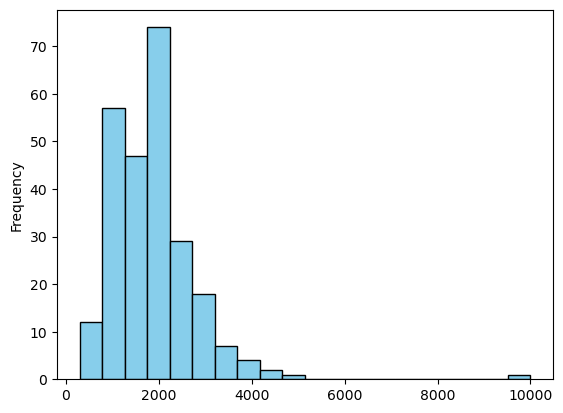

In [8]:
# Describir la columna min_salary
print("Descripción de la columna 'min_salary':")
print(trabajos_df['min_salary'].describe())

# Generar un histograma de la columna min_salary
trabajos_df['min_salary'].plot.hist(bins=20, color='skyblue', edgecolor='black')

Descripción de la columna 'max_salary':
count      252.000000
mean      2455.357143
std       1199.917440
min        450.000000
25%       1700.000000
50%       2300.000000
75%       3000.000000
max      10000.000000
Name: max_salary, dtype: float64


<Axes: ylabel='Frequency'>

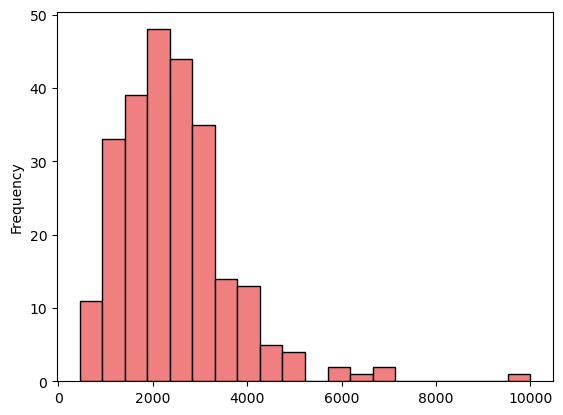

In [9]:
# Describir la columna max_salary
print("Descripción de la columna 'max_salary':")
print(trabajos_df['max_salary'].describe())

# Generar un histograma de la columna max_salary
trabajos_df['max_salary'].plot.hist(bins=20, color='lightcoral', edgecolor='black')

In [10]:
# Contar cuántos trabajos no tienen un salario mínimo especificado
trabajos_sin_salario_minimo = trabajos_df['min_salary'].isnull().sum()
print(f"Número de trabajos sin salario mínimo especificado: {trabajos_sin_salario_minimo}")

# Contar cuántos trabajos no tienen un salario máximo especificado
trabajos_sin_salario_maximo = trabajos_df['max_salary'].isnull().sum()
print(f"Número de trabajos sin salario máximo especificado: {trabajos_sin_salario_maximo}")


Número de trabajos sin salario mínimo especificado: 394
Número de trabajos sin salario máximo especificado: 394


In [11]:
# Generar una lista con los trabajos que si tengan salarios especificados
trabajos_con_salarios = trabajos_df[(trabajos_df['min_salary'].notnull()) & (trabajos_df['max_salary'].notnull())]


# Calcular el salario minimo promedio
salario_minimo_promedio = trabajos_con_salarios['min_salary'].mean()
print(f"Salario mínimo promedio: {salario_minimo_promedio:.2f}")

# Calcular el salario máximo promedio
salario_maximo_promedio = trabajos_con_salarios['max_salary'].mean()
print(f"Salario máximo promedio: {salario_maximo_promedio:.2f}")




Salario mínimo promedio: 1869.44
Salario máximo promedio: 2455.36


In [12]:
# Crear una matriz de transacciones para min_salary usando intervalos de 2000 en 2000 siendo 0 el mínimo y 10000 el máximo
min_salary_matrix = trabajos_con_salarios['min_salary'].apply(lambda x: [1 if x >= i and x < i + 2000 else 0 for i in range(0, 10001, 2000)]).tolist()

# Crear una matriz de transacciones para max_salary usando intervalos de 2000 en 2000 siendo 0 el mínimo y 10000 el máximo
max_salary_matrix = trabajos_con_salarios['max_salary'].apply(lambda x: [1 if x >= i and x < i + 2000 else 0 for i in range(0, 10001, 2000)]).tolist()

# Crear un DataFrame con la matriz de transacciones para min_salary y max_salary
salaries_df = pd.DataFrame(min_salary_matrix, columns=[f"min_salary_{i}-{i+2000}" for i in range(0, 10001, 2000)])
salaries_df = pd.concat([salaries_df, pd.DataFrame(max_salary_matrix, columns=[f"max_salary_{i}-{i+2000}" for i in range(0, 10001, 2000)])], axis=1)



In [13]:
# Extraer los datos de nuevo_df2 que tengan salarios
nuevo_df3 = nuevo_df2.loc[salaries_df.index]

# Juntar nuevo_df3 con salaries_df
nuevo_df3 = pd.concat([nuevo_df3, salaries_df], axis=1)

In [14]:
frequent_itemsets = apriori(nuevo_df2, min_support=0.1, use_colnames=True)

print("Ítems frecuentes encontrados:")
frequent_itemsets

/home/phil/anaconda3/envs/ICC732/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Ítems frecuentes encontrados:


,support,itemsets
0,0.747678,(CL)
1,0.190402,(Junior)
2,0.498452,(Semi Senior)
3,0.252322,(Senior)
4,0.119195,(fully_remote)
...,...,...
246,0.105263,"(hybrid, beverages_and_snacks, computer_provid..."
247,0.119195,"(remote_partial, hybrid, computer_provided, in..."
248,0.125387,"(Cloud Computing, Amazon Web Services, Cloud, ..."
249,0.100619,"(Cloud Computing, Cloud, computer_provided, Vi..."


In [15]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Filtrar y mostrar las reglas
# Seleccionamos las columnas más relevantes para mostrar: antecedentes, consecuentes, soporte, confianza y lift.
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("Reglas de asociación generadas:")
rules

Reglas de asociación generadas:


,antecedents,consequents,support,confidence,lift
0,(Junior),(CL),0.150155,0.788618,1.054756
1,(Semi Senior),(CL),0.380805,0.763975,1.021797
2,(CL),(Semi Senior),0.380805,0.509317,1.021797
3,(Senior),(CL),0.170279,0.674847,0.902590
4,(hybrid),(CL),0.438080,0.810888,1.084542
...,...,...,...,...,...
527,"(health_coverage, flexible_hours, informal_dre...",(computer_provided),0.108359,0.909091,1.545455
528,"(health_coverage, computer_provided, informal_...",(flexible_hours),0.108359,0.614035,1.695157
529,"(flexible_hours, computer_provided, informal_d...",(health_coverage),0.108359,0.534351,1.534182
530,"(health_coverage, flexible_hours)","(computer_provided, informal_dresscode)",0.108359,0.608696,1.702240


In [16]:
# Interpretación del resultado
# Iterar sobre cada regla para imprimir una interpretación más clara
for idx, rule in rules.iterrows():
    # Convertir los conjuntos de antecedentes y consecuentes en cadenas de texto
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    support = rule['support']
    confidence = rule['confidence']
    lift = rule['lift']
    
    # Imprimir la interpretación de cada regla
    print(f"Regla: {antecedents} -> {consequents}")
    print(f"  Soporte: {support:.2f}")
    print(f"  Confianza: {confidence:.2f}")
    print(f"  Lift: {lift:.2f}")
    print(f"  Interpretación: Si una aplicación es {antecedents}, hay una confianza del {confidence:.2%} de que también sea {consequents}. El lift de {lift:.2f} indica que esta relación es {lift:.2f} veces más probable que si los productos fueran independientes.\n")


Regla: Junior -> CL
  Soporte: 0.15
  Confianza: 0.79
  Lift: 1.05
  Interpretación: Si una aplicación es Junior, hay una confianza del 78.86% de que también sea CL. El lift de 1.05 indica que esta relación es 1.05 veces más probable que si los productos fueran independientes.

Regla: Semi Senior -> CL
  Soporte: 0.38
  Confianza: 0.76
  Lift: 1.02
  Interpretación: Si una aplicación es Semi Senior, hay una confianza del 76.40% de que también sea CL. El lift de 1.02 indica que esta relación es 1.02 veces más probable que si los productos fueran independientes.

Regla: CL -> Semi Senior
  Soporte: 0.38
  Confianza: 0.51
  Lift: 1.02
  Interpretación: Si una aplicación es CL, hay una confianza del 50.93% de que también sea Semi Senior. El lift de 1.02 indica que esta relación es 1.02 veces más probable que si los productos fueran independientes.

Regla: Senior -> CL
  Soporte: 0.17
  Confianza: 0.67
  Lift: 0.90
  Interpretación: Si una aplicación es Senior, hay una confianza del 67.48% 

Regla: health_coverage, Semi Senior -> CL, computer_provided
  Soporte: 0.14
  Confianza: 0.75
  Lift: 1.57
  Interpretación: Si una aplicación es health_coverage, Semi Senior, hay una confianza del 75.00% de que también sea CL, computer_provided. El lift de 1.57 indica que esta relación es 1.57 veces más probable que si los productos fueran independientes.

Regla: Semi Senior, CL, computer_provided -> informal_dresscode
  Soporte: 0.15
  Confianza: 0.59
  Lift: 1.28
  Interpretación: Si una aplicación es Semi Senior, CL, computer_provided, hay una confianza del 58.75% de que también sea informal_dresscode. El lift de 1.28 indica que esta relación es 1.28 veces más probable que si los productos fueran independientes.

Regla: Semi Senior, CL, informal_dresscode -> computer_provided
  Soporte: 0.15
  Confianza: 0.85
  Lift: 1.45
  Interpretación: Si una aplicación es Semi Senior, CL, informal_dresscode, hay una confianza del 85.45% de que también sea computer_provided. El lift de 1.45 in